In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import os, pickle, random
from datetime import datetime

In [2]:
get_after_QA = lambda s: s.split("DISIT/", 1)[1]

In [3]:
dati = pd.read_excel('/Users/lapotinacci/thesis/metric_datasets/vehicleFlow_dataset.xlsx')
dati = dati[dati["serviceUri"] == "http://www.disit.org/km4city/resource/iot/orionUNIFI/DISIT/METRO698"].copy()
sensor_name = get_after_QA(dati["serviceUri"].iloc[0])
dati.drop(columns=["serviceUri"], inplace=True)
print(dati.shape)

(190, 15)


In [4]:
# === Creazione cartella esperimento con timestamp ISO ===
timestamp = datetime.now().strftime("%H-%M-%S")
print(f"Ora inizio esperimento: {timestamp}")
day= datetime.now().strftime("%Y-%m-%d")
print(f"Giorno inizio esperimento: {day}")
exp_dir = f"../RISULTATI/{day}/esperimento_{sensor_name}_{timestamp}"

os.makedirs(exp_dir, exist_ok=True)

print(f"Cartella esperimento creata: {exp_dir}")

Ora inizio esperimento: 14-43-30
Giorno inizio esperimento: 2025-11-30
Cartella esperimento creata: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30


In [5]:
import ast

mask = ~dati['TTT'].str.contains("nan", na=True)
dtset_completo = dati[mask]

dtset_completo['TTT'] = dtset_completo['TTT'].apply(ast.literal_eval)

In [6]:
# Filtra le righe dove la colonna TTT ha lunghezza 24, ed elimina tutte le colonne le cui osservazioni sono indipendenti dal giorno
dtset_filtrato = dtset_completo[dtset_completo["TTT"].apply(lambda x: len(x) == 24)].sample(frac=1).reset_index(drop=True)
dtset_filtrato = dtset_filtrato[dtset_filtrato["type_of_TTT"] == "daily"]
len(dtset_filtrato)

90

In [7]:
import numpy as np


def is_useful_series(series, zero_ratio_thr=0.85, min_nonzero_value=0.1):
    arr = np.array(series, dtype=float)
    
    # Serie troppo corta
    if len(arr) <= 1:
        return False
    
    # Troppi zeri
    zero_ratio = (arr == 0).mean()
    if zero_ratio >= zero_ratio_thr:
        return False
    
    # Valore medio trascurabile (quasi zero)
    mean_val = np.mean(arr)
    if abs(mean_val) < min_nonzero_value:
        return False
    
    # Se arriva qui, la serie ha valori significativi
    return True

# Applica filtro
mask_useful = dtset_filtrato["TTT"].apply(is_useful_series)
df_useful = dtset_filtrato[mask_useful]

In [8]:
def spezza_serie_in_colonne(df, colonna_stringa, prefix='col_'):
    # --- Controllo colonna ---
    if colonna_stringa not in df.columns:
        raise ValueError(f"La colonna '{colonna_stringa}' non esiste nel DataFrame")

    result_df = df.copy()

    # Estraggo la colonna contenente gli embedding
    col = result_df.pop(colonna_stringa)

    embeddings = []

    for item in col:
        # Gestione valori nulli o vuoti
        if pd.isna(item) or item == "":
            embeddings.append([])
            continue
        
        # Se l'item è già una lista o un array (non stringa), lo gestiamo direttamente
        if isinstance(item, (list, np.ndarray)):
            embeddings.append(list(item))
            continue

        vett = None
        
        # --- TENTATIVO 1: Parsing Standard Python (es. "[1, 2, 3]") ---
        try:
            parsed = ast.literal_eval(item)
            if isinstance(parsed, (list, tuple)):
                vett = list(parsed)
        except (ValueError, SyntaxError):
            # Se fallisce (es. SyntaxError per mancanza di virgole), passiamo al tentativo 2
            pass

        # --- TENTATIVO 2: Parsing per Spazi (es. "[1 2 3]" o "1 2 3") ---
        if vett is None:
            try:
                # Rimuove parentesi quadre, tonde e spazi iniziali/finali
                clean_str = item.replace('[', '').replace(']', '').replace('(', '').replace(')', '').strip()
                
                # Se la stringa è vuota dopo la pulizia (es. "[]"), è una lista vuota
                if not clean_str:
                    vett = []
                else:
                    # .split() senza argomenti gestisce spazi multipli, tab e newline automaticamente
                    vett = [float(x) for x in clean_str.split()]
            except Exception as e:
                print(f"Errore nel parsing dell'elemento '{item}': {e}")
                vett = []

        # --- Conversione finale e check ---
        # Assicuro che tutti gli elementi siano float (utile se ast.literal_eval ha trovato interi)
        try:
            if vett:
                vett = [float(x) for x in vett]
            embeddings.append(vett)
        except Exception as e:
            print(f"Errore conversione float per '{item}': {e}")
            embeddings.append([])

    # --- Uniformo dimensione dei vettori ---
    lengths = [len(v) for v in embeddings]
    if not lengths or max(lengths) == 0:
        # Se non ci sono dati validi, restituisco il df senza la colonna oppure sollevo errore
        # Qui scelgo di restituire il df originale senza la colonna parsata per evitare crash
        print("Warning: Nessun embedding valido trovato.")
        return result_df

    max_len = max(lengths)

    # Padding con NaN
    embeddings_padded = [
        v + [np.nan] * (max_len - len(v)) if len(v) < max_len else v
        for v in embeddings
    ]

    # --- Creo DataFrame delle nuove colonne ---
    colonne_embedding = pd.DataFrame(
        embeddings_padded,
        index=result_df.index,
        columns=[f"{prefix}{i}" for i in range(max_len)]
    )

    # --- Merge col DataFrame originale ---
    return pd.concat([result_df, colonne_embedding], axis=1)

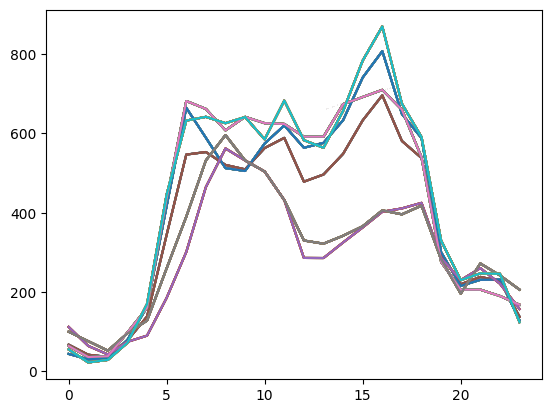

In [9]:
for ttt in df_useful.TTT:
    plt.plot(ttt)

In [10]:
def summary_df(df):
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'n_missing': df.isna().sum(),
        '%_missing': (df.isna().mean() * 100).round(2),
        'n_unique': df.nunique(),
        'top_value': df.mode().iloc[0],  # moda
        'top_freq': [df[col].value_counts(dropna=True).iloc[0] if not df[col].value_counts(dropna=True).empty else None for col in df.columns],
        'min': [df[col].min() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],
        'max': [df[col].max() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],
        'mean': [df[col].mean() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],
        'std': [df[col].std() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],
    })
    return summary


In [11]:
#Nella precedente sono state eliminate le colonne con Nan, tuttavia alcuni dataset dei sensori METRO hanno dei Nan in city e surface dunque vengono rimossi nel prcedente box

categorical = [
    'is_weekend'
    ]

#consiglio, per serie cicliche usare funzioni periodiche tipo seno coseno 
df_encoded = pd.get_dummies(df_useful
                            , columns=categorical)


In [12]:
def save_pkl(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"Salvato: {path}")

def load_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

In [13]:
#codifica ciclica delle features e individuazione del'ora del giorno e della settimana 

def encode_time_features(df, start_col="interval_start", end_col="interval_end"):
    df = df.copy()
    
    # Step 1: Ensure datetime columns are in the correct format first
    df[start_col] = pd.to_datetime(df[start_col], utc=True, format="mixed")
    df[end_col] = pd.to_datetime(df[end_col], utc=True, format="mixed")

    # Step 2: Extract 'month' and 'day' after conversion
    df['month'] = df[start_col].dt.month
    df['day'] = df[start_col].dt.dayofweek # Note: dayofweek is typically used for cyclical weekly patterns
    
    # Step 3: Now you can create the cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['month']/len(df['month'].unique()))
    df['month_cos'] = np.cos(2 * np.pi * df['month']/len(df['month'].unique()))
    df['day_sin'] = np.sin(2 * np.pi * df['day']/len(df['day'].unique()))
    df['day_cos'] = np.cos(2 * np.pi * df['day']/len(df['day'].unique()))


    # Ora del giorno (0-23) → ciclo giornaliero
    df["hour"] = df[start_col].dt.hour
    angle_day_start = 2 * np.pi * df["hour"] / 24
    df["start_time_sin"] = np.sin(angle_day_start)
    df["start_time_cos"] = np.cos(angle_day_start)

    df["hour_end"] = df[end_col].dt.hour
    angle_day_end = 2 * np.pi * df["hour_end"] / 24
    df["end_time_sin"] = np.sin(angle_day_end)
    df["end_time_cos"] = np.cos(angle_day_end)

    # Durata in minuti
    df["duration_minutes"] = (df[end_col] - df[start_col]).dt.total_seconds() / 60

    # Giorno della settimana (0=Mon..6=Sun) → ciclo settimanale
    dayofweek = df[start_col].dt.dayofweek
    angle_week = 2 * np.pi * dayofweek / 7
    df["dow_sin"] = np.sin(angle_week)
    df["dow_cos"] = np.cos(angle_week)

    # Giorno dell’anno (1-365) → ciclo annuale
    dayofyear = df[start_col].dt.dayofyear
    angle_year = 2 * np.pi * dayofyear / 365
    df["doy_sin"] = np.sin(angle_year)
    df["doy_cos"] = np.cos(angle_year)

    # Rimuovo colonne temporali e variabili ausiliarie
    df = df.drop(columns=[start_col, end_col, "hour", "hour_end", "day", "month"])
    return df

embedding_cols = ['highway_embeddings']

df_final = encode_time_features(df_encoded)
df_final.drop(columns=['type_of_TTT'], inplace=True)
for emb_col in embedding_cols:
    df_final = spezza_serie_in_colonne(df_final, emb_col, prefix=f'{emb_col}_')
df_final.shape

# Salvataggio DataFrame finale
df_path = os.path.join(exp_dir, f"dataframe_{sensor_name}")
os.makedirs(df_path, exist_ok=True)
save_pkl(df_final, os.path.join(df_path, f"filtered_dataframe.pkl"))


Salvato: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30/dataframe_METRO698/filtered_dataframe.pkl


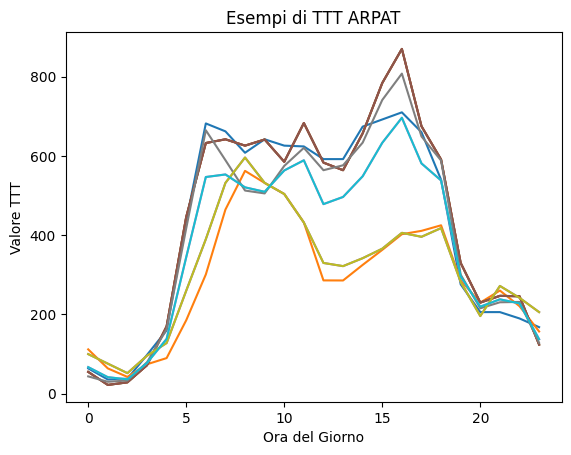

In [14]:
for ttt in df_final.TTT[10:20]:
    plt.plot(ttt)
    plt.title("Esempi di TTT ARPAT")
    plt.xlabel("Ora del Giorno")
    plt.ylabel("Valore TTT")

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

def series_to_2d_array(series, output_dim=24):
    arr = np.stack(series.apply(lambda x: np.array(x, dtype=np.float32)))
    if arr.shape[1] != output_dim:
        raise ValueError(f"Ogni elemento deve avere {output_dim} valori, trovato {arr.shape[1]}")
    return arr

 # Separazione delle feature e del target
X = df_final.drop(columns=['TTT'])
y = df_final['TTT']

X_np = X.to_numpy().astype(np.float32)
y_np = series_to_2d_array(y, output_dim=24)

# Calcolo deviazione standard per ogni serie
std_scores = np.std(y_np, axis=1)

std_scores_log = np.log1p(std_scores)  # log(1+x) per evitare problemi con valori vicini a 0

std_scores_normalized = (std_scores_log - np.min(std_scores_log)) / (np.max(std_scores_log) - np.min(std_scores_log))

# Creo bin basati sui quantili
bins = np.array([0.0, 0.4, 0.8, 1.0])
std_bins = np.digitize(std_scores_normalized, bins)

# Primo split: train (80%) vs temp (20%)
# Passo anche std_bins per poter stratificare
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np,
    test_size=0.2,
    random_state=42,
    stratify=std_bins, 
    shuffle=True
)

print(f"Train size: {X_train.shape}, {y_train.shape}")
print(f"Test size: {X_test.shape}, {y_test.shape}")

# Debug prints
print(f"Final shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

# Scaler per input
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test  = scaler_X.transform(X_test)

# Scaler per output (se serve normalizzare anche y)
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train)
y_test  = scaler_y.transform(y_test)

#cartella salvataggio train e test
path = os.path.join(exp_dir, "train_test_data")
os.makedirs(path, exist_ok=True)

#  === Salvataggio dataset e scaler in formato .pkl ===
save_pkl(scaler_X.inverse_transform(X_train), os.path.join('/Users/lapotinacci/thesis/Federated_Sys/train_test', f"X_train_unscaled_{sensor_name}.pkl"))
save_pkl(scaler_y.inverse_transform(y_train), os.path.join('/Users/lapotinacci/thesis/Federated_Sys/train_test', f"y_train_unscaled_{sensor_name}.pkl"))
save_pkl(scaler_X.inverse_transform(X_test), os.path.join('/Users/lapotinacci/thesis/Federated_Sys/train_test', f"X_test_unscaled_{sensor_name}.pkl"))
save_pkl(scaler_y.inverse_transform(y_test), os.path.join('/Users/lapotinacci/thesis/Federated_Sys/train_test', f"y_test_unscaled_{sensor_name}.pkl"))

save_pkl(X_train, os.path.join(exp_dir, "X_train.pkl"))
save_pkl(y_train, os.path.join(exp_dir, "y_train.pkl"))
save_pkl(X_test, os.path.join(exp_dir, "X_test.pkl"))
save_pkl(y_test, os.path.join(exp_dir, "y_test.pkl"))

save_pkl(scaler_X, os.path.join(exp_dir, "scaler_X.pkl"))
save_pkl(scaler_y, os.path.join(exp_dir, "scaler_y.pkl"))

print("Scaler salvati.")

print("\nTutti i file sono stati salvati correttamente.")
print(f"Percorso cartella: {os.path.abspath(exp_dir)}")

Train size: (72, 28), (72, 24)
Test size: (18, 28), (18, 24)
Final shapes:
X_train: (72, 28)
y_train: (72, 24)
Salvato: /Users/lapotinacci/thesis/Federated_Sys/train_test/X_train_unscaled_METRO698.pkl
Salvato: /Users/lapotinacci/thesis/Federated_Sys/train_test/y_train_unscaled_METRO698.pkl
Salvato: /Users/lapotinacci/thesis/Federated_Sys/train_test/X_test_unscaled_METRO698.pkl
Salvato: /Users/lapotinacci/thesis/Federated_Sys/train_test/y_test_unscaled_METRO698.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30/X_train.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30/y_train.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30/X_test.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30/y_test.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30/scaler_X.pkl
Salvato: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30/scaler_y.pkl
Scaler salvati.

Tutti i file sono stati salvati correttamente.
Percorso cartella

In [16]:
# === Costruisci i path ===
path_X_train = os.path.join(exp_dir, "X_train.pkl")
path_y_train = os.path.join(exp_dir, "y_train.pkl")
path_X_test  = os.path.join(exp_dir, "X_test.pkl")
path_y_test  = os.path.join(exp_dir, "y_test.pkl")

path_scaler_X = os.path.join(exp_dir, "scaler_X.pkl")
path_scaler_y = os.path.join(exp_dir, "scaler_y.pkl")

# === Ricaricamento ===
X_train = load_pkl(path_X_train)
y_train = load_pkl(path_y_train)
X_test  = load_pkl(path_X_test)
y_test  = load_pkl(path_y_test)


scaler_X = load_pkl(path_scaler_X)
scaler_y = load_pkl(path_scaler_y)

print("Shapes ricostruite:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

print("\nScaler caricati:")
print("scaler_X:", type(scaler_X))
print("scaler_y:", type(scaler_y))


Shapes ricostruite:
X_train: (72, 28)
y_train: (72, 24)
X_test: (18, 28)
y_test: (18, 24)

Scaler caricati:
scaler_X: <class 'sklearn.preprocessing._data.MinMaxScaler'>
scaler_y: <class 'sklearn.preprocessing._data.MinMaxScaler'>


# modelli

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers # type: ignore
from tensorflow.keras.layers import Dropout # type: ignore
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [18]:
def save_prediction_plots(y_true, y_pred, output_dir, prefix="pred_plot"):
    os.makedirs(output_dir, exist_ok=True)

    n = len(y_true)
    print(f"Salvo {n} plot in: {output_dir}")

    for i in range(n):
        plt.figure(figsize=(8, 3))
        plt.plot(y_true[i], label="True")
        plt.plot(y_pred[i], label="Pred")
        plt.legend()
        plt.tight_layout()

        filename = f"{prefix}_{i+1}.png"
        path = os.path.join(output_dir, filename)

        plt.savefig(path)
        plt.close()

    print("Plot salvati correttamente.")


In [19]:
# Definizione modello DNN
def build_model(input_shape: tuple, output_shape: tuple):
    model = models.Sequential([
        layers.Dense(256, activation = "relu", input_shape=input_shape),
        Dropout(0.0),
        layers.Dense(output_shape, 'linear')
    ])
    model.compile(
    optimizer=optimizers.AdamW(learning_rate=0.0125, weight_decay=0.105),
    loss= 'mse',
    metrics=['mae'],
    )
    return model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # metrica da monitorare, es. val_loss o val_mae
    patience=50,             # numero di epoche senza miglioramento prima di fermare
    restore_best_weights=True,  # ripristina i pesi migliori trovati
    verbose = 1
)

# Training del modello
model = build_model((X_test.shape[1],), y_test.shape[1])
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=64,
    callbacks = [early_stop],
    validation_split = 0.2,
    verbose=1
    )

'''print("y_train min/max:", y_train_np.min(), y_train_np.max())
print("y_pred min/max (scaled):", y_pred.min(), y_pred.max())
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
print("y_pred_rescaled min/max:", y_pred_rescaled.min(), y_pred_rescaled.max())'''

if not os.path.exists(os.path.join(exp_dir, "model")):
    os.makedirs(os.path.join(exp_dir, "model"))
    model.save(os.path.join(exp_dir, "model", "NO2_MAREMMA_model.keras"))


Epoch 1/1000


/Users/lapotinacci/thesis/Federated_Sys/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - loss: 0.4316 - mae: 0.5508 - val_loss: 0.1489 - val_mae: 0.3369
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1519 - mae: 0.3396 - val_loss: 0.1137 - val_mae: 0.2732
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1105 - mae: 0.2617 - val_loss: 0.1096 - val_mae: 0.2807
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1147 - mae: 0.2850 - val_loss: 0.0567 - val_mae: 0.1907
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0630 - mae: 0.2027 - val_loss: 0.0383 - val_mae: 0.1474
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0400 - mae: 0.1538 - val_loss: 0.0551 - val_mae: 0.1943
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0478 - mae: 0.1740 - val_loss: 0.0664 - val_mae: 0.2215
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0537 - mae: 0.1913 - val_loss: 0.0572 - val_mae: 0.2035
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0447 - mae: 0.1

In [20]:
model = tf.keras.models.load_model(f'{exp_dir}/model/NO2_{sensor_name}_model.keras') if os.path.exists(f'{exp_dir}/model/NO2_{sensor_name}_model.keras') else model

In [21]:
# Estrai losses da tutti i folds
train_losses = history.history['loss']
val_losses   = history.history['val_loss']

train_losses = train_losses
val_losses = val_losses

# Plot
plt.figure(figsize=(8,5))


# Training loss
plt.plot(train_losses, color='blue', label='Train Loss')
# Validation loss
plt.plot(val_losses, color='red', label='Validation Loss')


# Dettagli grafico
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(f'{exp_dir}/loss_plot.png')



In [22]:
def plot_first_n_series(y_pred, y_test, n_series=10, title="Confronto Serie Predette vs Reali"):
    """
    Plotta le prime n_series serie reali e predette per un confronto diretto.

    Args:
        y_pred (np.ndarray): Predizioni del modello (shape: num_samples x seq_len).
        y_test (np.ndarray): Serie reali (shape: num_samples x seq_len).
        n_series (int): Numero di serie da plottare.
        title (str): Titolo del grafico.
    """

    # Limitiamo a n_series per evitare problemi
    n = min(n_series, y_pred.shape[0], y_test.shape[0])

    plt.figure(figsize=(14, 8))

    for i in range(n):
        plt.plot(
            y_test[i], 
            linewidth=1.8, 
            alpha=0.5, 
            label=f"Reale {i+1}" if i == 0 else "",
            color = 'blue'
        )
        plt.plot(
            y_pred[i], 
            linewidth=1.2, 
            linestyle="--", 
            alpha=0.9, 
            label=f"Predetto {i+1}" if i == 0 else "",
            color = 'orange'
        )

    plt.title(title, fontsize=16)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Valore", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [23]:
import seaborn as sns

def plot_diagnosis_gradient(y_pred, y_test, save_path: str,  tolerance:float =0.05, max_samples_heatmap=50, scatter_sample_ratio=0.5, tol_auto = True):
    """
    Dashboard diagnostica con tolleranza AUTO-ADATTIVA alla scala dei dati.
    
    Args:
        tolerance (float): 
            - Se None: La tolleranza viene calcolata automaticamente come il 5% del range dei dati (Max-Min).
            - Se float: Valore assoluto (es. 0.5).
        tol_auto (bool): Se True, usa la tolleranza automatica basata sul range dei dati, altrimenti usa il valore manuale fornito 
        col parametro tolerance.
    """
    
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()

    # ---------------------------------------------------------
    # AUTOMAZIONE TOLLERANZA
    # ---------------------------------------------------------
    if tol_auto:
        data_range = y_test_flat.max() - y_test_flat.min()
        # Impostiamo la tolleranza al 5% del range totale (regolabile)
        tolerance = data_range * tolerance 
        tol_label = f"Auto (5% Range: ±{tolerance:.2f})"
    else:
        tol_label = f"Manuale (±{tolerance})"

    fig, axes = plt.subplots(1, 2, figsize=(22, 8))

    # -----------------------------
    # 1. HEATMAP (SX)
    # -----------------------------
    errors = np.abs(y_test - y_pred)
    errors_subset = errors[:max_samples_heatmap]
    
    # Adattiamo anche la scala colori della heatmap alla tolleranza
    # Tutto ciò che è oltre 3 volte la tolleranza è "errore massimo" visivo
    sns.heatmap(errors_subset, cmap="plasma", ax=axes[0], 
                vmax=tolerance * 3,
                cbar_kws={'label': 'Errore Assoluto'})
    
    axes[0].set_title(f"Heatmap Errori (Primi {max_samples_heatmap} campioni)", fontsize=16)
    axes[0].set_xlabel("Time Step", fontsize=12)
    axes[0].set_ylabel("Indice Campione", fontsize=12)

    # -----------------------------
    # 2. SCATTER CON SFONDO GRADIENTE (DX)
    # -----------------------------
    
    # Campionamento dati
    if scatter_sample_ratio < 1.0:
        mask = np.random.rand(len(y_test_flat)) < scatter_sample_ratio
        sample_test = y_test_flat[mask]
        sample_pred = y_pred_flat[mask]
    else:
        sample_test = y_test_flat
        sample_pred = y_pred_flat

    # Calcolo limiti grafico
    min_val = min(y_test_flat.min(), y_pred_flat.min())
    max_val = max(y_test_flat.max(), y_pred_flat.max())
    padding = (max_val - min_val) * 0.05
    plot_min = min_val - padding
    plot_max = max_val + padding

    # --- SFONDO GRADIENTE ---
    grid_x, grid_y = np.meshgrid(
        np.linspace(plot_min, plot_max, 200),
        np.linspace(plot_min, plot_max, 200)
    )
    grid_z = np.abs(grid_y - grid_x)

    im = axes[1].imshow(
        grid_z, 
        extent=(plot_min, plot_max, plot_min, plot_max), 
        origin='lower', 
        cmap='RdYlGn_r', 
        alpha=0.4, 
        vmax=tolerance * 4, # Il rosso satura a 4x della tolleranza
        aspect='auto'
    )

    # --- PUNTI BLU ---
    axes[1].scatter(
        sample_test, 
        sample_pred, 
        alpha=0.6, 
        s=15, 
        color='royalblue', 
        edgecolors='white', 
        linewidth=0.3,
        label='Campioni'
    )

    axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')

    # Metriche
    within_tol = np.mean(np.abs(y_test_flat - y_pred_flat) <= tolerance) * 100

    axes[1].set_title(
        f"Bontà delle previsioni con {tol_label}\nValori nel range di Tolleranza: {within_tol:.1f}%", 
        fontsize=16
    )
    axes[1].set_xlabel("Valore Reale", fontsize=12)
    axes[1].set_ylabel("Valore Predetto", fontsize=12)
    axes[1].set_xlim(plot_min, plot_max)
    axes[1].set_ylim(plot_min, plot_max)
    
    cbar = plt.colorbar(im, ax=axes[1], pad=0.02)
    cbar.set_label('Gravità Errore (Distanza da diagonale)')

    plt.tight_layout()
    plt.savefig(f'{exp_dir}/{save_path}.png')

In [24]:
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test_np = scaler_y.inverse_transform(y_test)

plot_diagnosis_gradient(y_pred, y_test_np, save_path='pred_quality', max_samples_heatmap=10, scatter_sample_ratio=0.7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_3356/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


In [25]:
save_prediction_plots(y_test_np, y_pred, output_dir=f'{exp_dir}/TEST', prefix="pred_plot")

Salvo 18 plot in: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30/TEST
Plot salvati correttamente.


In [26]:
import json
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_and_log(y_true, y_pred, log_path="log.json"):
    # --- Metriche ---
    mae = mean_absolute_error(y_true, y_pred, multioutput="uniform_average")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput="uniform_average"))

    mask = y_true != 0
    mape = float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0)

    r2 = r2_score(y_true, y_pred, multioutput="uniform_average")

    # Valore medio del test set
    v_mean = float(np.mean(y_true))

    # --- Stampa ---
    print(f"Test MAE: {mae:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test R2: {r2:.4f}")
    print(f"Valore medio del test set: {v_mean:.4f}")

    # --- Salvataggio log ---
    log_data = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
        "test_mean_value": v_mean
    }

    with open(log_path, "w") as f:
        json.dump(log_data, f, indent=4)

    print(f"\nLog salvato in: {log_path}")
evaluate_and_log(y_test_np, y_pred, log_path=f"{exp_dir}/evaluation_log.json")
# Impostazioni pandas per visualizzare tutti i dati

Test MAE: 0.0664
Test RMSE: 0.1057
Test MAPE: 0.02%
Test R2: 1.0000
Valore medio del test set: 380.4966

Log salvato in: ../RISULTATI/2025-11-30/esperimento_METRO698_14-43-30/evaluation_log.json


# globale e federato

In [27]:
fed = tf.keras.models.load_model('/Users/lapotinacci/thesis/Federated_Sys/app/custom/models/fed_model_Metro.keras')

model  = [fed]
model_name = ["federated"]

ValueError: File not found: filepath=/Users/lapotinacci/thesis/Federated_Sys/app/custom/models/fed_model_Metro.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
checkpoint_filepath = f'{exp_dir}/model/{sensor_name}_fed_model.keras'

# 2. Crea l'istanza della callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False, 
    verbose=1
)

In [ ]:
for model, name in zip(model, model_name):
    y_pred = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test_np = scaler_y.inverse_transform(y_test)

    print(f"--- {name} ---")
    #plot_diagnosis_gradient(y_pred, y_test_np, max_samples_heatmap=10, scatter_sample_ratio=0.7)
    evaluate_and_log(y_test_np, y_pred, log_path=f"{exp_dir}/{name.replace(' ', '_').lower()}_evaluation_log.json")
    save_prediction_plots(y_test_np, y_pred, output_dir=f'{exp_dir}/{name.replace(" ", "_").lower()}/TEST', prefix="pred_plot")

    print("\n")
    if name == 'federated':
        model.fit(X_train, y_train, epochs=1000, batch_size=64, callbacks=[early_stop], validation_split=0.2)
        model.load_weights(checkpoint_filepath)
        y_pred = model.predict(X_test)
        y_pred = scaler_y.inverse_transform(y_pred)
        print(f"--- {name} after local fine-tuning ---")
        plot_diagnosis_gradient(y_pred, y_test_np, save_path=f"{name}_pred_quality", max_samples_heatmap=10, scatter_sample_ratio=0.7)
        save_prediction_plots(y_test_np, y_pred, output_dir=f'{exp_dir}/{name.replace(" ", "_").lower()}_fd/TEST', prefix="pred_plot")
        evaluate_and_log(y_test_np, y_pred, log_path=f"{exp_dir}/{name.replace(' ', '_').lower()}_fd_evaluation_log.json")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
--- federated ---
Test MAE: 44.0879
Test RMSE: 60.7413
Test MAPE: 13.68%
Test R2: 0.1258
Valore medio del test set: 381.1454

Log salvato in: ../RISULTATI/2025-11-29/esperimento_METRO698_16-04-25/federated_evaluation_log.json
Salvo 18 plot in: ../RISULTATI/2025-11-29/esperimento_METRO698_16-04-25/federated/TEST
Plot salvati correttamente.


Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1238 - mae: 0.2892 - mse: 0.1238  
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0966 - mae: 0.2527 - mse: 0.0966
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0754 - mae: 0.2172 - mse: 0.0754
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0644 - mae: 0.1920 - mse: 0.0644
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0571 - mae: 0.1759 - mse: 0.0571
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0461 - mae: 0.1547 - mse: 0.0461
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

/var/folders/1s/vnvjtlb516n5mswtv7rf58b80000gn/T/ipykernel_96883/2011710758.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[1].plot([plot_min, plot_max], [plot_min, plot_max], 'k--', alpha=0.5, label='Perfetto (y=x)', color = 'red')


Plot salvati correttamente.
Test MAE: 3.1641
Test RMSE: 4.9394
Test MAPE: 0.80%
Test R2: 0.9973
Valore medio del test set: 381.1454

Log salvato in: ../RISULTATI/2025-11-29/esperimento_METRO698_16-04-25/federated_fd_evaluation_log.json
